# Import neccessary modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm
from matplotlib.widgets import RangeSlider
import pandas as pd
import h5py
from numpy import savetxt
from numpy import loadtxt

import pickle, pprint


from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic
from scipy import interpolate
from scipy.special import wofz
import scipy.sparse as sparse
from scipy.signal import find_peaks
import scipy.interpolate as interp



from pandas import Series, DataFrame
from pandas.core.common import flatten

import sys
import os

from lmfit import CompositeModel,  Model, Parameters
from lmfit.lineshapes import gaussian, step
from pandas.api.types import CategoricalDtype

#information on how to install flashdaqutils can be found here: https://gitlab.desy.de/christopher.passow/flash-daq-hdf

import flashdaqhdfutils as fdu 

%matplotlib widget
#%matplotlib inline

### Define data path and DAQ channels to be used for the analysis

In [2]:
datadir = '/asap3/flash/gpfs/pg1/2023/data/11017909/raw/hdf/offline/fl1user3'

usrdaq_channels = {
    "/FL1/Beamlines/PG/Monochromator/monochromator photon energy": "energy", 
    "/uncategorised/TTF2.FEL/HASVUVPGFW3.CAM/PIXIS": "images",
    "/uncategorised/FLASH.SYNC/LASER.LOCK.EXP/F1.PG.OSC/FMC0.MD22.1.ENCODER_POSITION.RD": "delay",
    "/uncategorised/FLASH.LASER/FLASH1MODPG1.BEAMSTAB/BTPG1.BEAMSTAB/STATE.NEARFIELD.Y" : "laserPX",
    "/FL1/Photon Diagnostic/GMD/Average energy/energy tunnel": "GMD",
    "/uncategorised/FLASH.SDIAG/BAM.DAQ/FL1.SFELC.ARRIVAL_TIME.ABSOLUTE": "TimeArrival_SFELC",
    "/uncategorised/FLASH.SDIAG/BAM.DAQ/FL0.DBC2.ARRIVAL_TIME.ABSOLUTE": "TimeArrival_DBC",
}

# define functions

In [3]:
def get_usrdaq_run(runno, directory, channels, daq = "fl1user3"):
    """
    Input:
    daq: see the fdu function 'run_files' in the file 'flashdaqhdfutils.py'.
    One of 'pbd', 'pbd2', 'fl1user1', 'fl1user2', 'fl1user3', 'fl2user1', 'fl2user2'
    """
    
    if type(runno) is list:
        print(f'Reading multiple files of runs {runno}')
        all_files_of_run = []
        for run in runno:
            files = [directory+'/'+file for file in os.listdir(directory) if str(run) in file] 
            all_files_of_run = all_files_of_run + files
    else:
        print(f'Reading single file of run {runno}')
        all_files_of_run = fdu.run_files(runno, directory=directory, daq=daq)
    df = fdu.files_dsets_data_frame(all_files_of_run, channels)
    if 'GMD' in str(channels.values()):
        df.GMD = df.GMD.interpolate(method='linear')
    if 'energy' in str(channels.values()):
        df['energy'] = df['energy'].interpolate(method='pad') # Fill in NaNs using existing values.
        
    if 'image' in str(channels.values()):
        df = df[df['images'].notna()]
        ## Add Image shape as metadata
        df.image_shape = df.images.iloc[1].shape 
        
    if 'diode' in str(channels.values()): #diode channel indicates integrated pulse
        df['diode'] = df['diode'].interpolate(method="pad") #shows those values which are not NAN
        
    if 'pulse' in str(channels.values()): # pulse channel indicates the raw pulses
        df = df[df['pulse'].notna()]
        
    if 'delay' in str(channels.values()):
        df['delay'] = df['delay'].interpolate(method='linear')
        
    if 'laserdiode' in str(channels.values()): #during delayhopping one can check whether the laser shutter is ON or OFF
        df['laserdiode'] = df['laserdiode'].interpolate(method="pad") #shows those values which are not NAN
        df=df[df['laserdiode'].notna()]
    
    return(df)

###
# en_axis generates energy axis from pixels for the given spectrum, dispersion (one has to calculate it in advance), elastic peak position and interval begin and end.
# Peak position and interval limits are used to find the barycenter of the possibly distorted elastic line and assign the barrycenter to 0 eV energy
# dispersion in eV/px is used further to convert pixles to eV starting from 0 eV position.
# 'offset' is needed for manual 0-position adjustment if elastic line was not fully visible or recorded 

def en_axis(spectrum, peak, dispersion, Interval_begin, Interval_end, offset):
    pixel=np.linspace(0,spectrum.size-1,spectrum.size)
    barycenter1=np.nansum(pixel[peak-Interval_begin:peak+Interval_end]*spectrum[peak-Interval_begin:peak+Interval_end])/np.nansum(spectrum[peak-Interval_begin:peak+Interval_end])
    en_loss_axis=((barycenter1-pixel)*(dispersion/1000))-offset
    return(en_loss_axis)

def midpoints(x): # finds mid points for bin intervals for example
    return (x[1:] + x[:-1])/ 2

def get_bins(desired_binwidth, vals): # defines time windows bins of time resolved data 
    minval = np.min(vals)
    maxval = np.max(vals)
    diff = maxval - minval
    diff/desired_binwidth
    edges = np.arange(minval-desired_binwidth/2, maxval+desired_binwidth, desired_binwidth)
    mids = midpoints(edges)
    return(edges, mids)

def norm_to_peak(enax, spec, peak_pos_eV: tuple, return_normfact = False): # normalize a spectrum to an integrated area under the given peak
    """normalize a spectrum to an integrated area"""
    region = (enax > peak_pos_eV[0]) & (enax < peak_pos_eV[1])
    region_intensity = np.mean(spec[region])
    if return_normfact:
        return(spec/region_intensity, region_intensity)
    else:
        return(spec/region_intensity)

def normalize(spectra_stack, baselineregion_pix = np.s_[200:624]): # normalize a stack of spectra to their number and subtract a baseline from the far anti-stokes region
    
    norm_to_nims = spectra_stack / spectra_stack.shape[0]
    meanspec = norm_to_nims.mean()
    baseline_intensity = np.mean(meanspec[baselineregion_pix])
    return(norm_to_nims - baseline_intensity)

### sum of elements of 1d array 'spectrum' in the region(start,end), where start and end are given in eV
### x is 1d array, i.e. the energy axis in eV, which has to be calculated in advance for the given spectrum  
def slice_sum(region, x, spectrum): 
    
    abs_val_start = np.abs(x - region[0])#finds modulus of (x-start of the region)
    index_start = abs_val_start.argmin()#gets index of element in X array corresponding to the minimal difference between given region value and x array element
    start_element = spectrum[index_start]# provides the value of the element, optional
    abs_val_end = np.abs(x - region[1])
    index_end = abs_val_end.argmin()
    end_element = spectrum[index_end]
    s_sum=np.nansum(spectrum[index_end:index_start])
    nums_in_slice=spectrum[index_end:index_start].size
    
    return(s_sum,nums_in_slice)

def norm_to_GMD(spectra, GMD): # normalization to the GMD signal
    
    normed = spectra / GMD
    return(normed)

def subtract_baseline(enax, spec, baselineroi_eV = (-20,-5)): # subtract baseline from a spectrum, taken from a roi, defined in units eV
    
    enaxroi = (enax > baselineroi_eV[0]) & (enax < baselineroi_eV[1])
    intensity = np.mean(spec[enaxroi])
    return(spec-intensity)

# #For the binning, I use a group function, that tells the pandas function 'groupby' what it is supposed to do
# #with the column in the datraframe that does not only consist of scalar values ( in this case the column 'spectra')
# def groupfunction(MesGroup, roi = None):
#     """
#     The MesGroup is a Pandas Object that contains all the events that fall into the "bin"
#     """
#     try:
#         meanspec= MesGroup['fin_drop_bad'].sum()/MesGroup['fin_drop_bad'].shape[0]
        
#     except:
#         #if it is 0 (when the delaybin is empty. these will be dropped anyway
#         meanspec= MesGroup['fin_drop_bad'].mean()
#     Nims_in_bin = MesGroup['fin_drop_bad'].shape[0]
#     std_in_bin = np.std( MesGroup['fin_drop_bad'].mean()/np.sqrt(Nims_in_bin))
    
#     return pd.Series(index = ['mean_spectra', 'Nims_in_bin', 'std_in_bin'],data = [meanspec, Nims_in_bin, std_in_bin])

###Making spectra out of CCD images listed in the dataframe and correcting them for the given background and normilizing the spectra to GMD,and area under the spectrum
### dataframe names for the background and spectrum must be given as function arguments
###example: spectrum100=get_spectrum(bck99,run43550,drop1, drop2), drop1, drop2 - defines the region of bad pixels to be excluded from the analysis
def get_spectra (bck, run, drop1, drop2): #makes averaged spectrum out of all runs
    
    bck['images']= bck.images.apply(np.float64).dropna() #detector image
    bck['spectra'] = bck.images.apply(np.mean, axis=0) #making individual spectra from each image in the run
    bckspec=bck['spectra'].mean()#making averaged spectrum for the run
    bckFinal=bckspec#/bckGMD #assigning spectrum to a new variable, !it is optional!

    run['images']= run.images.apply(np.float64).dropna() #detector image
    run['spectra'] = run.images.apply(np.mean, axis=0)
    runspec=run['spectra'].mean()
    runGMD=run['GMD'].mean() #getting averaged GMD value for the given run
    runspecBck=runspec-bckFinal #correcting the averaged RIXS spectrum for background 
    runEnorm=runspecBck/runGMD #normalizing the RIXS averaged spectrum to the FEL intensity (GMD)
    baseline=np.nanmean(runEnorm[1500:2000]) # define the remaining baseline as mean value of the CCD signal from the antistockes side where no RIXS is
    runfinal=runEnorm-baseline # correct for baseline 
    runfinal[drop1:drop2]=np.nan # drop off corrupted pixels from e.g. d1=891 to drop2=905, if drop1=drop2 the command will be ignored, so no drops
    runfinalSUM=np.nansum(runfinal) # getting area under the spectrum
    runfinal=runfinal/runfinalSUM # normalizing RIXS spectrum to its area
    return(runfinal)

def get_rixs (bck, run, drop1, drop2):#makes averaged spectra of each train ID and saved them into dataframe sorted by index
    bck['images']= bck.images.apply(np.float64).dropna() #detector image
    bck['spectra'] = bck.images.apply(np.mean, axis=0) #making individual spectra from each image in the run
    bckspec=bck['spectra'].mean()#making averaged spectrum for the run
    bckFinal=bckspec#/bckGMD #assigning spectrum to a new variable, !it is optional!
###
    run['images']= run.images.apply(np.float64).dropna() #detector image
    run['spectra'] = run.images.apply(np.mean, axis=0)
    runGMD=run['GMD'].mean() #getting averaged GMD value for the given run
    run['corrBCK']=run.spectra.apply(lambda x: (x-bckFinal)) #correcting the averaged RIXS spectrum for background and
                                                                    #normalizing the RIXS averaged spectrum to the FEL intensity (GMD or I0)
    run['baseline']=run.corrBCK.map(lambda x: np.mean(x[1500:2000]))# define the remaining baseline as mean value of the CCD signal from the antistockes side where no RIXS is
    run['fin']=run['corrBCK']-run['baseline'] # correct for baseline 
    
#     ### if I0 momitor was used for FEL intensity normalization, use this part of the function:
#     run['Intensity']= run['I0'].apply(np.float64)
#     run['Intensity']= run['I0'].apply(lambda x: x[:60000])
#     run['I0cor']= run['Intensity'].apply(lambda x: BaselineRemoval(x).ZhangFit())
#     run['I0abssum']=run['I0cor'].apply(np.abs)
#     run['I0mean']=run['I0abssum'].apply(np.sum)
#     run['spI0']=run['spectra'].truediv(run['I0mean'], axis=0)
#     run['baseline']=run['spI0'].map(lambda x: np.mean(x[1500:2000]))# define the remaining baseline as mean value of the CCD signal from the antistockes side where no RIXS is
#     run['fin']=run['spI0']-run['baseline'] # correct for baseline 
    

    ## drop bad pixels from drop1 till drop2
    #if drop1=drop2 the command will be ignored, so no drops
    def set_nan(x,drop1, drop2):
        x[drop1:drop2] = np.nan
        return x
    run['fin_drop_bad']= run['fin'].apply(lambda x: set_nan(x, drop1, drop2))
       
    return(run)

# Step 1:RIXS MAP

### import Runs

In [4]:
### check the spectrum in manual mode and define elastic peak position and interval for energy axis calibration

bkg653 = get_usrdaq_run([43653], datadir, usrdaq_channels, daq= 'fl1user3')
bkg653['images']= bkg653.images.apply(np.float64).dropna()
bkg653['spectra'] = bkg653.images.apply(np.mean, axis=0)#detector image
bkg653spec=bkg653['spectra'].mean()
bck653GMD=bkg653['GMD'].mean()
bck653Enorm=bkg653spec
bck653final=bck653Enorm

Reading multiple files of runs [43653]


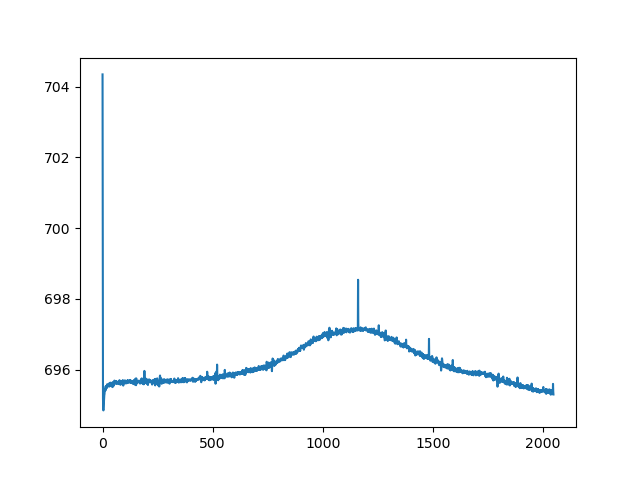

In [5]:
plt.figure()
plt.plot(bck653final)

### RIXS at 10 eV energy loss focus

In [16]:
###101.25 eV TRIXS focus at 10eV loss

run673 = get_usrdaq_run(43673, datadir, usrdaq_channels, daq= 'fl1user3')

run101p25eV=get_spectra(bkg653,run673,891,904) # take run 43673 and subtract background from the run 43653 prepared in the cell above  891,904

#elastic line center of mass position CM = 1450, dispersion=13.488meV/px, integrate from px 14 before the CM  till 15 px after CM, offset=0px 
x101p25eV=en_axis(run101p25eV, 1450, 13.488, 14, 15,0)

Reading single file of run 43673


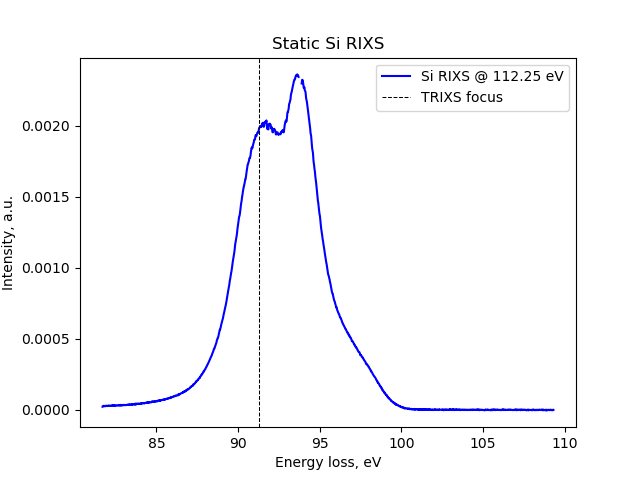

In [17]:
plt.figure()
plt.title("Static Si RIXS")
plt.xlabel("Energy loss, eV")
plt.ylabel("Intensity, a.u.")
plt.plot(101.25-x101p25eV,run101p25eV,'b', label = "Si RIXS @ 112.25 eV")
plt.axvline(x = 91.25, linestyle ='--', linewidth =0.75, color = 'k', label = 'TRIXS focus')
plt.legend(loc="upper right")
plt.show()

### Time resolved measurements

In [18]:
runlist = [43673] # put run numbers separated by comma

run = get_usrdaq_run(runlist, datadir, usrdaq_channels, daq= 'fl1user3')

Reading multiple files of runs [43673]


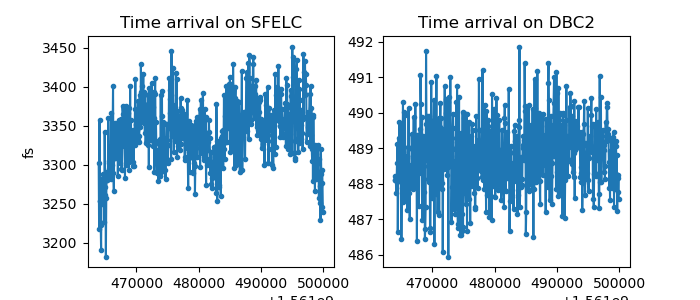

In [19]:
## Ploting BAM data to check if BAM has driffted during the runs
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.title("Time arrival on SFELC")
plt.plot(run.TimeArrival_SFELC.apply(lambda x: np.nanmean(x[x!=0], axis=0)),'.-', label = "TimeArrival_SFELC")

plt.ylabel('fs')
plt.subplot(1,2,2)
plt.title("Time arrival on DBC2")
plt.plot(run.TimeArrival_DBC.apply(lambda x: np.nanmean(x[x!=0], axis=0)),'.-', label = "TimeArrival_DBC")

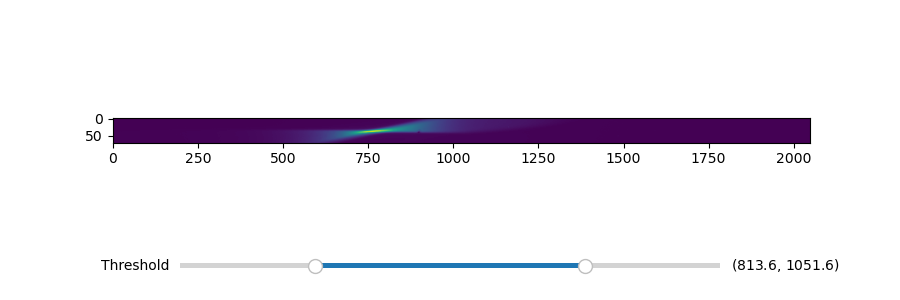

In [20]:
#Plot example image of RIXS

fig, axs = plt.subplots(1, figsize=(9, 3))
fig.subplots_adjust(bottom=0.25)

run['images']= run.images.apply(np.float64).dropna()
h=run['images'].mean()

im = plt.imshow(h)

# Create the RangeSlider
slider_ax = fig.add_axes([0.20, 0.1, 0.60, 0.03])
slider = RangeSlider(slider_ax, "Threshold", h.min(), h.max())

def update(val):
    # The val passed to a callback by the RangeSlider will
    # be a tuple of (min, max)

    # Update the image's colormap
    im.norm.vmin = val[0]
    im.norm.vmax = val[1]

    # # Update the position of the vertical lines
    # lower_limit_line.set_xdata([val[0], val[0]])
    # upper_limit_line.set_xdata([val[1], val[1]])

    # Redraw the figure to ensure it updates
    fig.canvas.draw_idle()

slider.on_changed(update)
plt.show(h)

In [21]:
## BAM correction for the laser delay line relative position
t0 = 2942.5 #time zero found before via transient reflectivity measurments in advance during the beamtimne
run['BAM']=run['TimeArrival_SFELC'].apply(lambda x: np.nanmean(x[x!=0], axis=0)/1000)
run['delayBAM']=run['delay']-(run['BAM'].iloc[0]-run['BAM'])

In [22]:
### preparing background for RIXS correction

bkg = get_usrdaq_run([43653], datadir, usrdaq_channels, daq= 'fl1user3') # preprare background spectrum
# bkg['images']= bkg.images.apply(np.float64).dropna()
# bkg['spectra'] = bkg.images.apply(np.mean, axis=0)#detector image
# bkgspec=bkg['spectra'].mean()
# bkgGMD=bkg['GMD'].mean()
# bkgEnorm=bkgspec#/bck524GMD
# bkgfinal=bkgEnorm

Reading multiple files of runs [43653]


### Splitting run into bins (BAM corrected)

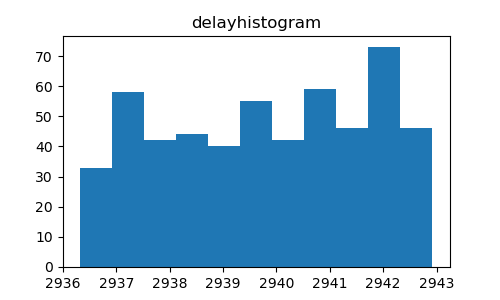

In [23]:
#bin width for delaybinning
desired_delaybinwidth = 0.6 #ps
delayvals = np.asarray(run['delayBAM'])

# calculate bin edges from min value to max value with chosen spacing
delaybin_edges = np.arange(run['delayBAM'].min()-desired_delaybinwidth/2, run['delayBAM'].max()+desired_delaybinwidth/2,desired_delaybinwidth)
#print(run['delayBAM'].max(), run['delayBAM'].min())

#plot histogram of delayhopping
plt.figure(figsize = (5,3))
plt.title("delayhistogram")
delayhist = plt.hist(delayvals,bins=delaybin_edges)
hist=np.histogram(delayvals,bins=delaybin_edges)


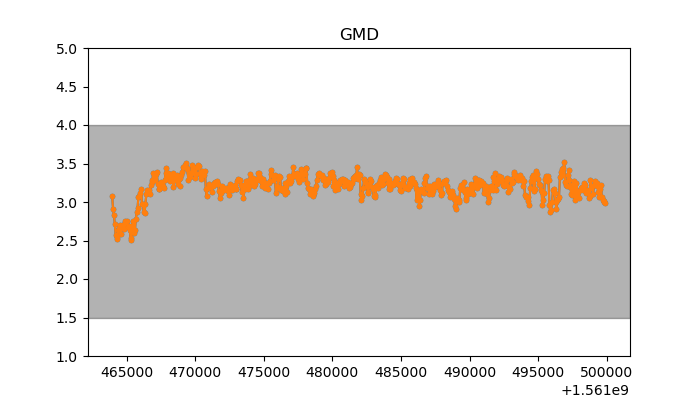

In [24]:
### check GMD value and use it as a mask (filter) for good data
plt.figure(figsize=(7,4))
plt.title("GMD")
plt.plot(run.GMD,'.-', label = "GMD")

GMDfilter = [1.5,4]
GMDmask = (run.GMD>GMDfilter[0]) & (run.GMD<GMDfilter[1])
plt.plot(run.GMD[GMDmask],'.-', label = "GMD")
plt.axhspan(*GMDfilter, alpha = 0.3, color = 'k')
plt.ylim(1,5)

Total_mask = GMDmask
Filteredrun = run[Total_mask]


### plot delaystage position of imported run, BAM corrected

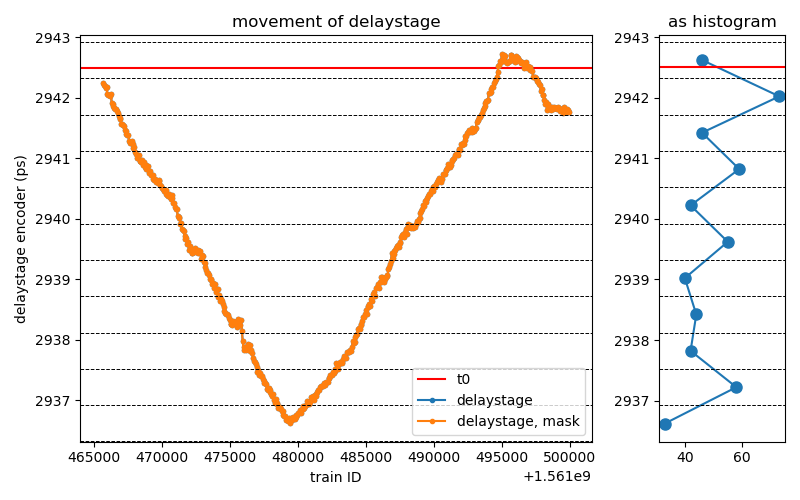

In [25]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(8,5))

gs = gridspec.GridSpec(ncols=4, nrows=1)
plt.subplot(gs[0,:3])
plt.title("movement of delaystage")
plt.axhline(t0, color= "r", label = "t0")
plt.plot(run['delayBAM'][:],'.-', label = "delaystage")
plt.plot(run['delayBAM'][Total_mask],'.-', label = "delaystage, mask")

for i in delaybin_edges:
    plt.axhline(i, ls = "--", c="k", lw=0.7)
plt.xlabel("train ID")
plt.ylabel("delaystage encoder (ps)")
plt.legend()
plt.subplot(gs[0,3])
plt.title("as histogram")
plt.plot(delayhist[0], midpoints(delayhist[1]), "o-", ms=8)
plt.axhline(t0, color= "r", label = "t0")
for i in delaybin_edges:
    plt.axhline(i, ls = "--", c="k", lw=0.7)
plt.ylim(run['delayBAM'].min()-desired_delaybinwidth/2, run['delayBAM'].max()+desired_delaybinwidth/2)

plt.tight_layout()

### sort filtered data bassed on delay binning and define pixels for 0 energy loss calcualtions

In [26]:
data1 = Filteredrun.copy()
data=get_rixs(bkg, data1, 890, 904)

In [27]:
new_df = data[['delayBAM','fin_drop_bad']].copy() #with BAM correction

new_df=new_df.dropna()

#lt.figure()
spectr_averaged=data['fin_drop_bad'].sum(axis=0)/data['fin_drop_bad'].size
#lt.plot(spectr_averaged)

## visualize the results

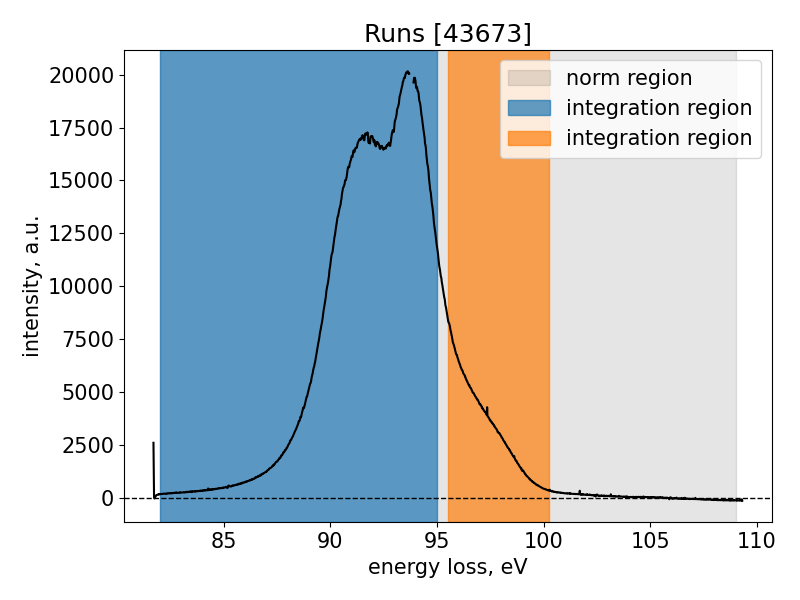

In [28]:
nspec = new_df.shape[0]
clr_idx = np.linspace(0,1,nspec)

# defines ROIs for normalization and integration

enaxis=en_axis(new_df.fin_drop_bad.iloc[0], 1450, 13.488,14,15,0) # 91.25 eV focus

enaxis=101.25-enaxis # E emission instead of E loss

norm_region = (109,82) #normalization region 

int_regions_eV = [(82,95),(95.5,100.25)] #E region to be used later to analyse time dependences in them 

plt.figure(figsize = (8,6))
enaxes = []
meanspecs = []
normfacts = []
offset = 0
#iterate over delaybins
for i, val in enumerate(new_df.delayBAM):#BAM corrected
    #mean spectrum in current bin
    this_spectrum =(data.iloc[i]['fin_drop_bad'])
       
    this_enax = enaxis
     
    #normalize mean spectrum
    Emask = (this_enax > norm_region[0]) & (this_enax < norm_region[1])
    this_spectrum = this_spectrum/np.sum(this_spectrum[Emask])
    this_spectrum, this_peaknormfact = norm_to_peak(this_enax, this_spectrum-offset*i, norm_region, return_normfact=True)
    
    #append spectrum and energy axis to lists
    enaxes.append(this_enax)
    meanspecs.append(this_spectrum)
    normfacts.append(this_peaknormfact)
    
mean_sp=np.stack(meanspecs)
plt.rcParams.update({'font.size': 15})

#plt.plot(enaxis, spectr_preview, 'k')
plt.plot(enaxes[0], spectr_averaged, 'k')

plt.axvspan(*norm_region, alpha = 0.1,color = 'k', label = 'norm region')
for i, r in enumerate(int_regions_eV):
    plt.axvspan(*r, alpha = 0.7,color = plt.cm.tab10(i/10), label = 'integration region')
plt.legend(ncol=2,title = "delay (ps); pos = pumped")
plt.legend()
plt.xlabel("energy loss, eV")#, fontsize=20)
plt.ylabel("intensity, a.u.")#, fontsize=20)
plt.axhline(0, ls='--', c='k', lw=1)
plt.title(f'Runs {runlist}')
plt.tight_layout()
plt.show()


### TR-RIXS in multiple regions

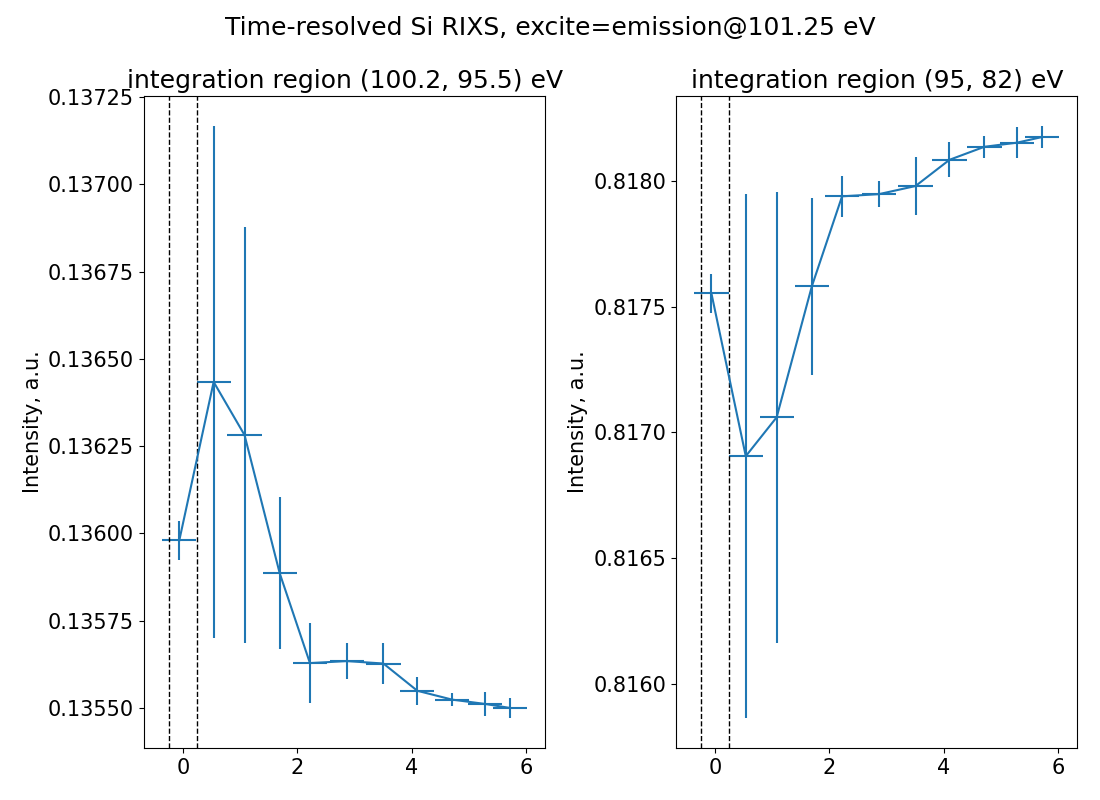

In [29]:
#Note in the list int_regions_eV = (101.1,100.8) - first put larger number, than smaller

int_regions_eV = [(100.2,95.5),(95,82)] #excitation at 112.2eV, spectrometer focused at 91.25eVV

region=norm_region #norm region taken from previous cell

len(int_regions_eV)
plot = []

m=0
for m in range (len(int_regions_eV)):

    spectr=[]
    time=[]
    stdvTest=[]
    int1Test=[]
    stdv_prelim=[]
    i=0
    for i in range (delaybin_edges.size-1):

        rslt_df = new_df.loc[(new_df['delayBAM'] >= delaybin_edges[i]) & (new_df['delayBAM'] < delaybin_edges[i+1])]
        if (rslt_df.shape[0]) < 1: # drop the bin if number of images in it is below 10 (could be any number) (for statistical reasons)
            continue
        time.append(np.nanmean(np.asarray(rslt_df['delayBAM'])))
        del_time_rel_1=np.stack(time)
    
        spectr=np.stack(np.asarray(rslt_df['fin_drop_bad']))
    
        j=0
        normF=[]
        sp_N=[]
    
        for j in range(spectr.shape[0]):
            normF.append(slice_sum(region,enaxis,spectr[j])[0])
            sp_N.append(spectr[j]/normF[j])
        specN=np.stack(sp_N)
        sp_mean=np.nanmean(specN, axis=0)
                        
        k=0
        int1=[]
        
        for k in range(spectr.shape[0]):
            int1.append(slice_sum(int_regions_eV[m],enaxis,specN[k])[0])

        int_reg1=np.stack(int1)
        int_reg_mean=np.nanmean(int_reg1, axis=0)

        stdvInt1=np.std(int_reg1)
    
        stdvTest.append(stdvInt1)
        int1Test.append(int_reg_mean)
    
    st_test=np.stack(stdvTest)
    in1_test=np.stack(int1Test)
    #del_time_rel=t0-del_time_rel_1
    del_time_rel=np.stack(t0-del_time_rel_1)

    trixs_region=np.array([del_time_rel, in1_test,st_test]).T
    plot.append(trixs_region)
    
plot=np.array(plot) 
p0=plot[0] 
p1=plot[1] 

fig, axs = plt.subplots(1, 2, figsize=(11,8))

fig.suptitle('Time-resolved Si RIXS, excite=emission@101.25 eV')

plt.subplot(1, 2, 1)
plt.title(f'integration region {int_regions_eV[0]} eV')
plt.errorbar(p0[:,0],p0[:,1],yerr =p0[:,2], xerr = desired_delaybinwidth/2)

plt.ylabel('Intensity, a.u.')
plt.axvline(-0.25, ls='--', c='k', lw=1)
plt.axvline(-0+0.25, ls='--', c='k', lw=1)

plt.subplot(1, 2, 2)
plt.title(f'integration region {int_regions_eV[1]} eV')
plt.errorbar(p1[:,0],p1[:,1],yerr =p1[:,2], xerr = desired_delaybinwidth/2)
plt.ylabel('Intensity, a.u.')
plt.axvline(-0.25, ls='--', c='k', lw=1)
plt.axvline(-0+0.25, ls='--', c='k', lw=1)

fig.tight_layout()
plt.show()